# Lake model continued - subspace partitioning

In the previous week you used the lake problem as a means of getting acquainted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of the [open exploration tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## 1. Apply scenario discovery

1. Instanciate the model and define its parameters. Use the same parameters as in Assignment 2.
2. Generate 10 policies and 1000 scenarios and evaluate them.
3. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop_columns`*
4. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability

In [24]:
from lakemodel_function import lake_problem

In [25]:
from ema_workbench import Policy
import pandas as pd

# Instantiate the model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
)

model = Model("lakeproblem", function=lake_problem)
# Specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# Set levers, one for each time step
model.levers = [RealParameter(f'l{i}', 0, 0.1) for i in range(100)]


# Specify outcomes
model.outcomes = [
    ScalarOutcome('max_P'),
    ScalarOutcome('utility'),
    ScalarOutcome('inertia'),
    ScalarOutcome('reliability')
]

from ema_workbench import SequentialEvaluator
with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=10)  # Adjust number of scenarios as needed
    
    
experiments = experiments.drop(columns=[f'l{i}' for i in range(100)])
experiments

    

100%|██████████████████████████████████| 10000/10000 [00:07<00:00, 1354.39it/s]


,b,delta,mean,q,stdev,scenario,policy,model
0,0.249305,0.938205,0.049881,2.081516,0.002516,11473,11463,lakeproblem
1,0.120976,0.945982,0.041334,4.270878,0.001792,11474,11463,lakeproblem
2,0.176091,0.951642,0.013150,3.373813,0.004380,11475,11463,lakeproblem
3,0.423888,0.940253,0.047333,4.166018,0.002162,11476,11463,lakeproblem
4,0.129717,0.951049,0.022420,3.322413,0.003064,11477,11463,lakeproblem
...,...,...,...,...,...,...,...,...
9995,0.178063,0.942847,0.044803,2.017536,0.004833,12468,11472,lakeproblem
9996,0.352580,0.986096,0.048469,2.385379,0.001568,12469,11472,lakeproblem
9997,0.377763,0.963996,0.021727,3.516984,0.003028,12470,11472,lakeproblem
9998,0.249566,0.937569,0.024919,2.104378,0.002370,12471,11472,lakeproblem


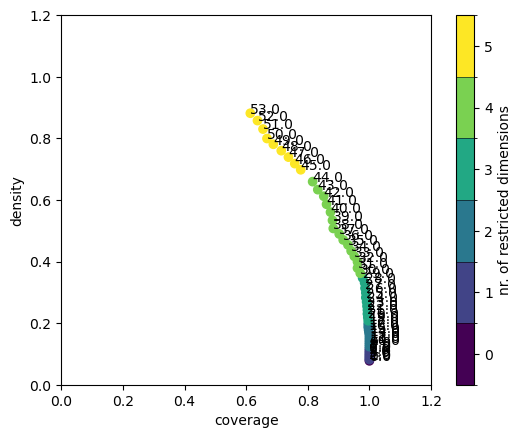

In [26]:
from ema_workbench.analysis import prim

# Step 5: Apply scenario discovery
x = experiments
y = outcomes['reliability'] < np.percentile(outcomes['reliability'], 10)  # Focus on the worst 10% outcomes

prim_alg = prim.Prim(x, y, threshold=0.8)   
box = prim_alg.find_box()

box.show_tradeoff(annotated=True)
plt.show()

## 2. Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?